# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком.

**Цель исследования** - построить модель, прогнозирующую отток клиентов. Ключевая метрика `F1-мера`.

**Ход исследования**

Данные о поведении клиентов получим из файла `Churn.csv`. О качестве данных ничего неизвестно, поэтому будем производить осмотр данных.

Исследования пройдет в несколько этапов:
* Осмотр и обработка данных;
* Построение baseline моделей;
* Улучшение моделей;
* Прогноз на тестовой выборке.

## Осмотр и обработка данных.

Импортируем необходимые библиотеки.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

sns.set(style="whitegrid")

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.dummy import DummyClassifier

from sklearn.metrics import f1_score, plot_roc_curve

from sklearn.model_selection import GridSearchCV, train_test_split, cross_validate
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

from sklearn.utils import shuffle

from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector as selector

Считаем данные из файла `Churn.csv`

In [3]:
df = pd.read_csv('/datasets/Churn.csv')

Посмотрим на данные и получим общую информацию о данных с помощью метода `info()`

In [4]:
df

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


**Признаки**:
* `RowNumber` — индекс строки в данных
* `CustomerId` — уникальный идентификатор клиента
* `Surname` — фамилия
* `CreditScore` — кредитный рейтинг
* `Geography` — страна проживания
* `Gender` — пол
* `Age` — возраст
* `Tenure` — сколько лет человек является клиентом банка
* `Balance` — баланс на счёте
* `NumOfProducts` — количество продуктов банка, используемых клиентом
* `HasCrCard` — наличие кредитной карты
* `IsActiveMember` — активность клиента
* `EstimatedSalary` — предполагаемая зарплата

**Целевой признак**:
* `Exited` — факт ухода клиента

Посмотрим есть ли дубликаты строк.

In [6]:
df.duplicated().sum()

0

**Вывод**

Выявленные ошибки в данных:
* В данных есть пропуски в столбце `tenure`;
* Наименование столбцов некорректное. Присутствует верхний регистр, а так же записаны не в змеином регистре.

Дубликаты в данных отсутсвуют.

Исправим наименование столбцов.

In [7]:
df.columns

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

In [8]:
df.columns = pd.Series(['Row_Number', 'Customer_Id', 'Surname', 'Credit_Score', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'Num_Of_Products', 'Has_Cr_Card',
       'Is_Active_Member', 'Estimated_Salary', 'Exited']).str.lower()

In [9]:
df.columns

Index(['row_number', 'customer_id', 'surname', 'credit_score', 'geography',
       'gender', 'age', 'tenure', 'balance', 'num_of_products', 'has_cr_card',
       'is_active_member', 'estimated_salary', 'exited'],
      dtype='object')

Исключим из данных незначимые столбцы.

In [10]:
unnecessary_columns = ['row_number', 'customer_id', 'surname']

df = df.drop(columns=unnecessary_columns, axis=1)

Исследуем корреляции между признаками с помощью `sns.pairplot` и `sns.heatmap`

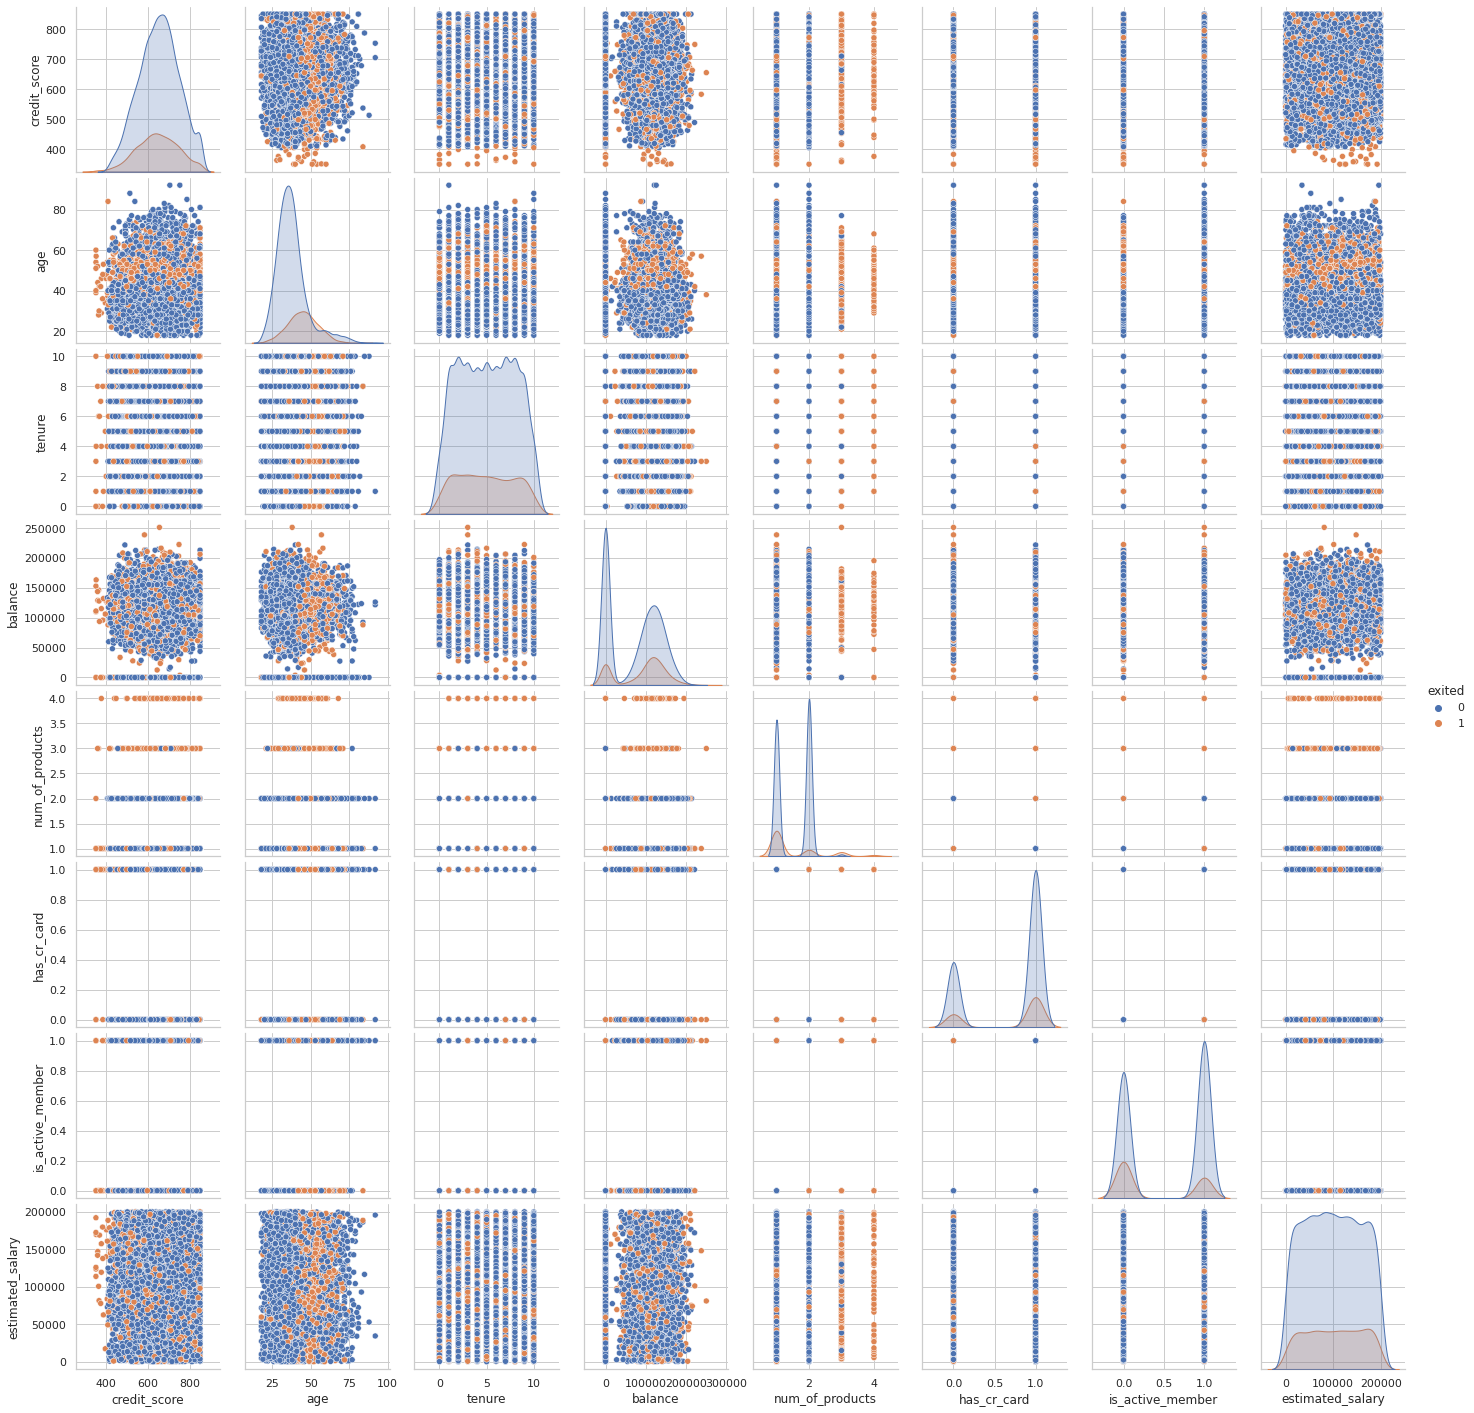

In [11]:
sns.pairplot(df, hue='exited');

Построим отдельно некоторые зависимости.

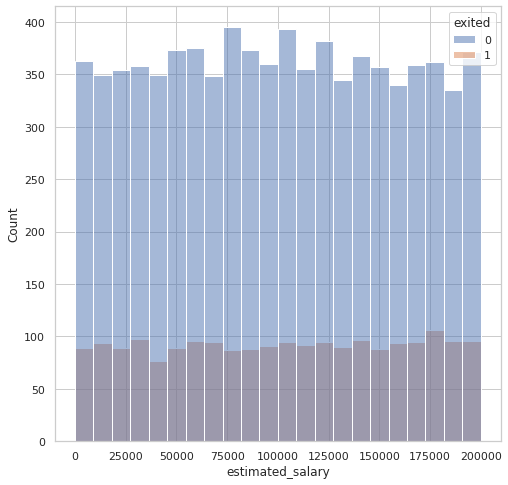

In [12]:
f, ax = plt.subplots(figsize=(8,8))

sns.histplot(x='estimated_salary', hue='exited', data=df);

Предполагаемые зарплаты распределены очень равномерно, что странно.

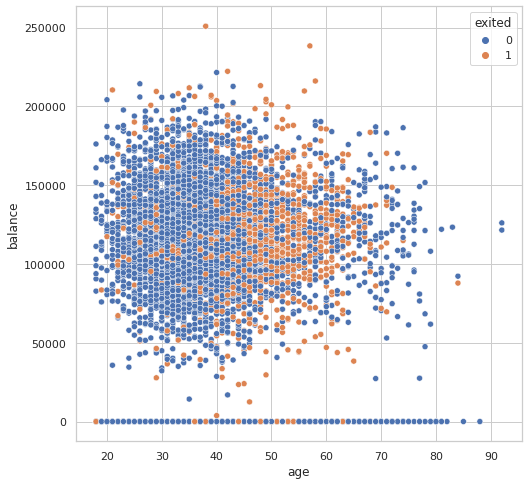

In [13]:
f, ax = plt.subplots(figsize=(8,8))

sns.scatterplot(x='age', y='balance', hue='exited', data=df);

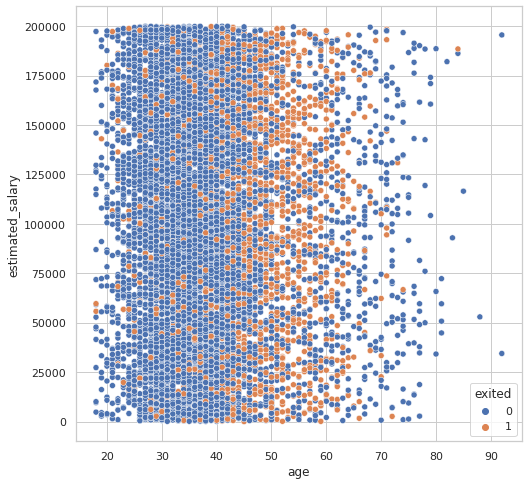

In [14]:
f, ax = plt.subplots(figsize=(8,8))

sns.scatterplot(x='age', y='estimated_salary', hue='exited', data=df);

В графиках наблюдается явный коридор возрастов, где уходит большинство клиентов.

In [15]:
df['age_bin'] = df['age'] // 5

Посмотрим на процент ушедших по категориям возрастов. А так же посмотрим на среднюю зарплату для категорий.

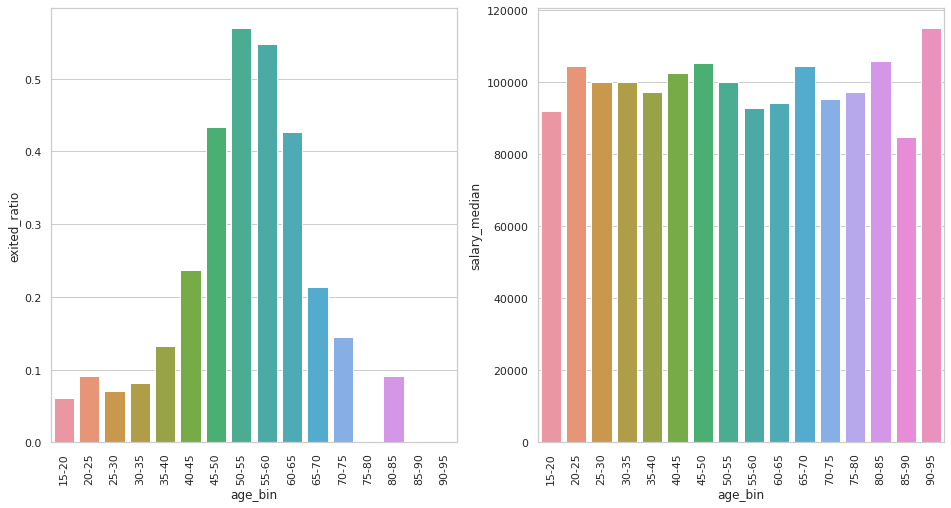

In [16]:
data_group_age = df.groupby('age_bin').agg({'exited' : ['sum', 'count'],
                                            'estimated_salary' : 'mean'})

data_group_age = data_group_age.reset_index()
data_group_age
data_group_age.columns = ['age_bin', 'exited', 'clients', 'salary_median']

data_group_age['exited_ratio'] = data_group_age['exited'] / data_group_age['clients']

dct = {}

for i in range(3, 19):
    dct[i] = f'{i*5}-{(i+1)*5}'
    
data_group_age['age_bin'] = data_group_age['age_bin'].map(dct)

f, ax = plt.subplots(1, 2, figsize=(16,8))

sns.barplot(x='age_bin', y='exited_ratio', data=data_group_age, ax=ax[0]);
ax[0].tick_params(axis='x', rotation=90)

sns.barplot(x='age_bin', y='salary_median', data=data_group_age, ax=ax[1]);
ax[1].tick_params(axis='x', rotation=90)

Больше 50% клиентов уходят в возрастных категориях от 45 до 65 лет.

Рассмотрим столбец `tenure`.

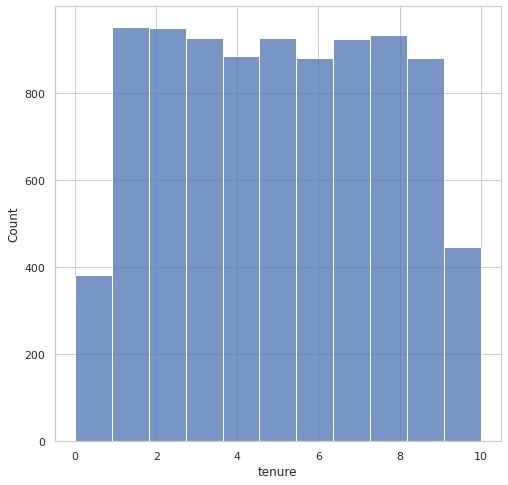

In [17]:
f, ax = plt.subplots(figsize=(8,8))

sns.histplot(x='tenure', bins=11, data=df);

Распределение выглядит очень равномерно, за исключением 0 и 10 лет.

Предлагаю заполнить пропуски случайным значением 0 или 10, и добавить в датасет флаг, который бы обозначал пропуск в данном месте.

In [18]:
# df['tenure_is_na'] = df['tenure'].apply(lambda val: 1 if np.isnan(val) else 0)

In [19]:
# df['tenure'] = df['tenure'].apply(lambda val: np.random.choice([0, 10]) if np.isnan(val) else val)

In [20]:
df = df.dropna()

Переназначим категории возрастов в исходном датафрейме.

In [21]:
df['age_bin'] = df['age_bin'].map(dct)

**Вывод**

В данном разделе была проведена работа с данными, удалены пропуски, а так же добавлен столбец с информацией, к какой возрастной группе принадлежит каждый из клиентов.

По результатам анализа выяснилось, что свыше 50% клиентов уходит в возрастной категории от 50 до 60 лет, что является очень высоким показателем.

## Работа с признаками.

Разделим все признаки из датасета на категориальные и количественные.

**Категориальные**
1. `geography`,
2. `gender`,
3. `tenure`,
4. `num_of_products`,
5. `has_cr_card`,
6. `is_active_member`,
7. `exited`.

**Количественные**
1. `credit_score`,
2. `age`,
3. `balance`,
4. `estimated_salary`.

Предположим, что если у клиента баланс счета больше, чем его предполагаемая зарплата, то у такого клиента имеется депозит в банке.

In [22]:
def has_deposit(row):
    
    balance = row['balance']
    salary = row['estimated_salary']
    
    return int(balance > salary)

In [23]:
df['has_deposit'] = df.apply(has_deposit, axis=1)

Переведем признаки в соответствие с их категорией.

In [24]:
df['tenure'] = df['tenure'].astype('category')
df['num_of_products'] = df['num_of_products'].astype('category')
df['has_cr_card'] = df['has_cr_card'].astype('category')
df['is_active_member'] = df['is_active_member'].astype('category')
# df['tenure_is_na'] = df['tenure_is_na'].astype('category')
df['has_deposit'] = df['has_deposit'].astype('category')
df['geography'] = df['geography'].astype('category')
df['gender'] = df['gender'].astype('category')
df['age_bin'] = df['age_bin'].astype('category')

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9091 entries, 0 to 9998
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   credit_score      9091 non-null   int64   
 1   geography         9091 non-null   category
 2   gender            9091 non-null   category
 3   age               9091 non-null   int64   
 4   tenure            9091 non-null   category
 5   balance           9091 non-null   float64 
 6   num_of_products   9091 non-null   category
 7   has_cr_card       9091 non-null   category
 8   is_active_member  9091 non-null   category
 9   estimated_salary  9091 non-null   float64 
 10  exited            9091 non-null   int64   
 11  age_bin           9091 non-null   category
 12  has_deposit       9091 non-null   category
dtypes: category(8), float64(2), int64(3)
memory usage: 499.0 KB


Исследуем корреляцию между признаками.

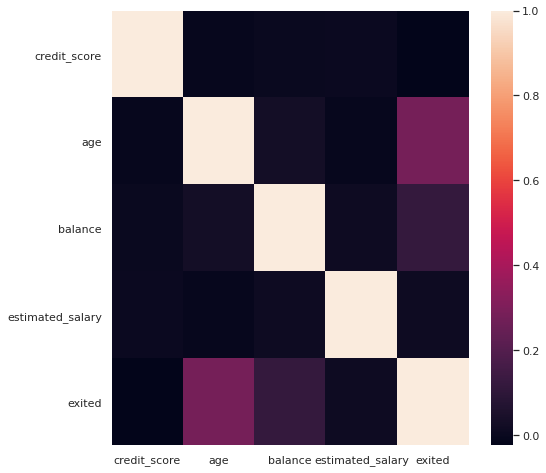

In [26]:
f, ax = plt.subplots(figsize=(8,8))

sns.heatmap(df.corr());

**Вывод**

В данном разделе была произведена работа с признаками. Значимых корреляций в датасете не обнаружено. Так же создали дополнительный признак наличия у клиента банковского счета.

## Построение baseline моделей.

Построим baseline модели для датасета. Будем использовать 3 модели для классификации:
1. `LogisticRegression`
2. `RandomForest`
3. `Support Vector Machine`

Посмотрим на распределение признаков в датасете.

In [27]:
df['exited'].value_counts(normalize=True)

0    0.796062
1    0.203938
Name: exited, dtype: float64

В имеющихся данных присутствует сильный дисбаланс классов. Построим модели с этим дисбалансом.

Разделим датасет на тренировочный/валидационный/тестовый.

In [28]:
features, target = df.drop(columns=['exited']), df['exited']

X_train, X_temp, y_train, y_temp = train_test_split(features, target, stratify=target,
                                                    test_size=0.4, random_state=17)

X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, stratify=y_temp,
                                                    test_size=0.5, random_state=17)

len(features) == len(X_train) + len(X_test) + len(X_valid)

True

In [29]:
y_train.value_counts(normalize=True)

0    0.796113
1    0.203887
Name: exited, dtype: float64

In [30]:
y_valid.value_counts(normalize=True)

0    0.79593
1    0.20407
Name: exited, dtype: float64

In [31]:
y_test.value_counts(normalize=True)

0    0.796042
1    0.203958
Name: exited, dtype: float64

Данные успешно разделены.

Для дальнейшей работы создадим класс `model_scores`, который будет сохранять результаты отработки моделей.

In [32]:
class model_scores(dict):
    
    '''
    Класс, наследованный от словаря, который сохраняет в себе
    результат работы моделей.
    '''
    
    def __init__(self, scoring_dict):
        
        '''
        Инициирование класса.
        На вход подается словарь с необходимыми метриками.
        Так же создается список model_index, куда будут складываться названия моделей.
        '''
        self.scores = scoring_dict
        self.model_index = []
        
    def add_metrics(self, metrics):
        '''
        Загрузка необходимых метрик для append_model.
        '''
        self.metrics = metrics
        
    def input_data(self, data_train, target_train, data_valid, target_valid):
        
        '''
        Инициализация входных данных для тренировки и валидации моделей.
        '''
        
        self.X_train = data_train
        self.y_train = target_train
        self.X_valid = data_valid
        self.y_valid = target_valid
    
    def append_model(self, model, model_name):
        
        '''
        На вход подается модель и ее имя.
        Затем происходит кросс-валидация модели методом cross_validate и 
        усредненные результаты записываются в словарь self.scores.
        Затем происходит валидация модели на данных, которые она не видела,
        результат так же заносится в словарь.
        '''
        
        self.model_index.append(model_name)
        cv_result = cross_validate(model, self.X_train, self.y_train, scoring=self.metrics)
        
        for metric in self.metrics:
            self.scores[metric].append(cv_result['test_'+f'{metric}'].mean())
        
        model.fit(self.X_train, self.y_train)
        pred = model.predict(self.X_valid)
        f1 = f1_score(self.y_valid, pred)
        
        if self.scores.get('f1_score_valid'):
            self.scores['f1_score_valid'].append(f1)
        else:
            self.scores['f1_score_valid'] = []
            self.scores['f1_score_valid'].append(f1)
    
    def print_scores(self):
        
        '''
        Вывод словаря в виде pd.DataFrame
        '''
        return pd.DataFrame(self.scores, index=self.model_index)

Создадим метрики, по которым хотим отслеживать качество моделей. Создадим экземпляр класса.

In [33]:
metrics = ['accuracy', 'balanced_accuracy', 'recall', 'precision', 'f1']
scores = {'accuracy': [], 'balanced_accuracy': [], 'recall': [], 'precision': [], 'f1': []}

result = model_scores(scores)
result.add_metrics(metrics)
result.input_data(X_train, y_train, X_valid, y_valid)

Создадим для нашего датасета пайплайн, который будет стандартизировать наши данные и выполнять OHE с категориальными признаками, которые мы обозначили ранее.

In [34]:
num_pipe_lr = make_pipeline(
    StandardScaler()
)
cat_pipe_lr = make_pipeline(
    OneHotEncoder(handle_unknown="ignore"),
)

preprocessor = make_column_transformer(
    (num_pipe_lr, selector(dtype_include="number")),
    (cat_pipe_lr, selector(dtype_include="category"))
)

Приступим к тренировке моделей.

### Dummy baseline

0.3046757164404223


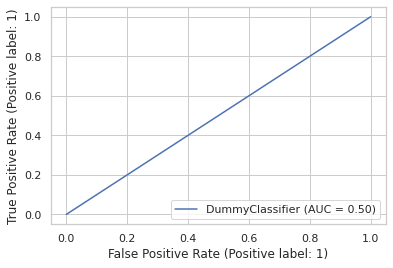

In [35]:
dummy_clf = DummyClassifier(strategy='uniform')

dummy_clf.fit(X_train, y_train)

predict = dummy_clf.predict(X_valid)

print(f1_score(y_valid, predict))

plot_roc_curve(dummy_clf, X_valid, y_valid);

### LogisticRegression

In [36]:
lr_clf = make_pipeline(preprocessor, LogisticRegression(random_state=17))

result.append_model(lr_clf, 'LogisticRegression (baseline)')

### RandomForestClassifier

In [37]:
rf_clf = make_pipeline(
    preprocessor, RandomForestClassifier(random_state=17)
)

result.append_model(rf_clf, 'RandomForest (baseline)')

### SVM

In [38]:
SVM_clf_linear = make_pipeline(
    preprocessor, svm.SVC(kernel='linear', random_state=17)
)


SVM_clf_rbf = make_pipeline(
    preprocessor, svm.SVC(kernel='rbf', random_state=17)
)

SVM_clf_poly = make_pipeline(
    preprocessor, svm.SVC(kernel='poly', random_state=17)
)

LinearSVC_clf_linear = make_pipeline(
    preprocessor, svm.LinearSVC(random_state=17)
)

result.append_model(SVM_clf_linear, 'SVM linear (baseline)')
result.append_model(SVM_clf_rbf, 'SVM rbf (baseline)')
result.append_model(SVM_clf_poly, 'SVM poly (baseline)')
result.append_model(LinearSVC_clf_linear, 'LinearSVC (baseline)')

### Итоги

In [39]:
baseline = result.print_scores()

baseline

,accuracy,balanced_accuracy,recall,precision,f1,f1_score_valid
LogisticRegression (baseline),0.852584,0.703361,0.451400,0.722627,0.554217,0.557596
RandomForest (baseline),0.859002,0.710730,0.460381,0.752125,0.570450,0.524871
SVM linear (baseline),0.850568,0.687374,0.411825,0.743528,0.528784,0.540351
SVM rbf (baseline),0.856435,0.689397,0.407353,0.784919,0.535781,0.535971
SVM poly (baseline),0.855885,0.696748,0.428041,0.760489,0.547458,0.531469
LinearSVC (baseline),0.854418,0.701162,0.442395,0.741356,0.552147,0.547009


**Выводы**

1. Из всех моделей лучше всего показывают себя Логистическая регрессия и Случайный лес, f1 - 0.55/0.53 соответственно, что больше, чем у случайных моделей.
2. У всех моделей практически не наблюдается переобучение, кроме SVM poly и Random Forest, их показатели на валидации упали примерно на 5%.

## Улучшение моделей.

Для начала учтем дисбаланс классов. Исследуем 3 метода борьбы с дисбалансом:
1. `Upsample`;
2. `Downsample`;
3. `class_weight='balance'`

### Upsample

Данный метод состоит в том, чтобы размножить множество всех примеров, где целевой признак равен 1.

In [40]:
def upsample(features, target, repeat):
    
    '''
    На вход функции подаются данные, целевой признак и то количество, во сколько необходимо
    увеличить выборку с целевым признаком ==1.
    На выходе функция возвращает преобразованные данные.
    '''
    
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=17)
    
    return features_upsampled, target_upsampled

Произведем сэмплирование.

In [41]:
X_train_upsample, y_train_upsample = upsample(X_train, y_train, 4)

Рассмотрим соотношение целевого признака в обновленных данных.

In [42]:
y_train_upsample.value_counts(normalize=True)

1    0.50603
0    0.49397
Name: exited, dtype: float64

Дисбаланс преодолен.

In [43]:
metrics = ['accuracy', 'balanced_accuracy', 'recall', 'precision', 'f1']
scores = {'accuracy': [], 'balanced_accuracy': [], 'recall': [], 'precision': [], 'f1': []}

result = model_scores(scores)
result.add_metrics(metrics)
result.input_data(X_train_upsample, y_train_upsample, X_valid, y_valid)

#### LogisticRegression Upsample

In [44]:
result.append_model(lr_clf, 'LogisticRegression (upsample)')

#### RandomForest Upsample

In [45]:
result.append_model(rf_clf, 'RandomForest (upsample)')

#### SVM upsample

In [46]:
result.append_model(SVM_clf_linear, 'SVM linear (upsample)')
result.append_model(SVM_clf_rbf, 'SVM rbf (upsample)')
result.append_model(SVM_clf_poly, 'SVM poly (upsample)')
result.append_model(LinearSVC_clf_linear, 'LinearSVC (upsample)')

#### Итоги

In [47]:
upsample = result.print_scores()

upsample

,accuracy,balanced_accuracy,recall,precision,f1,f1_score_valid
LogisticRegression (upsample),0.770193,0.770307,0.761020,0.779955,0.770206,0.572308
RandomForest (upsample),0.952560,0.952023,0.996402,0.917099,0.955094,0.572271
SVM linear (upsample),0.772014,0.772251,0.752700,0.787773,0.769641,0.575884
SVM rbf (upsample),0.815245,0.815194,0.819473,0.816639,0.817840,0.594895
SVM poly (upsample),0.822298,0.822085,0.839703,0.815073,0.827112,0.577434
LinearSVC (upsample),0.773720,0.773909,0.758322,0.787095,0.772304,0.575851


**Вывод**

Техника `upsample` помогла улучшить результаты для всех моделей примерно на 5%. Так же можно увидеть, что на кросс-валидации модели сильно переобучались.

### Downsample

Данная техника является обратной `upsample`. В данном случае мы уменьшим количество тех примеров, где признак будет равняться 0.

In [48]:
def downsample(features, target, fraction):
    
    '''
    На вход функции подаются данные, целевой признак и то количество, какую часть необходимо
    взять с целевым признаком ==0.
    На выходе функция возвращает преобразованные данные.    
    '''
    
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=17)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=17)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=17)
    
    return features_downsampled, target_downsampled

Произведем сэмплирование.

In [49]:
X_train_downsample, y_train_downsample = downsample(X_train, y_train, 0.3)

Рассмотрим соотношение целевого признака в обновленных данных.

In [50]:
y_train_downsample.value_counts(normalize=True)

0    0.539545
1    0.460455
Name: exited, dtype: float64

Дисбаланс преодолен.

In [51]:
metrics = ['accuracy', 'balanced_accuracy', 'recall', 'precision', 'f1']
scores = {'accuracy': [], 'balanced_accuracy': [], 'recall': [], 'precision': [], 'f1': []}

result = model_scores(scores)
result.add_metrics(metrics)
result.input_data(X_train_downsample, y_train_downsample, X_valid, y_valid)

####  LogisticRegression Downsample

In [52]:
result.append_model(lr_clf, 'LogisticRegression (downsample)')

####  RandomForest Downsample

In [53]:
result.append_model(rf_clf, 'RandomForest (downsample)')

#### SVM Downsample

In [54]:
result.append_model(SVM_clf_linear, 'SVM linear (downsample)')
result.append_model(SVM_clf_rbf, 'SVM rbf (downsample)')
result.append_model(SVM_clf_poly, 'SVM poly (downsample)')
result.append_model(LinearSVC_clf_linear, 'LinearSVC (downsample)')

#### Итоги

In [55]:
downsample = result.print_scores()

downsample

,accuracy,balanced_accuracy,recall,precision,f1,f1_score_valid
LogisticRegression (downsample),0.771843,0.768235,0.722175,0.768901,0.744421,0.591549
RandomForest (downsample),0.772257,0.769843,0.739224,0.760245,0.749079,0.574302
SVM linear (downsample),0.767702,0.763342,0.707793,0.769690,0.736992,0.593577
SVM rbf (downsample),0.780952,0.777251,0.730259,0.780028,0.754199,0.604144
SVM poly (downsample),0.782195,0.778987,0.738331,0.777694,0.757426,0.570506
LinearSVC (downsample),0.769358,0.765269,0.713182,0.769261,0.739906,0.594951


**Вывод**

Данная техника помогла улучшить результат сильнее, чем `upsample` и дала прирост в среднем на 6%. Модели так же переобучаются, но слабее.

Так же заметим, что некоторые модели на валидации уже показывают порог более 0.59 по метрике F1.

### class_weight = 'balanced'

Следущей техникой является уравновешивание классов внутри алгоритмов.
Для этого в алгоритмах будем передавать `class_weight=balanced`

In [56]:
metrics = ['accuracy', 'balanced_accuracy', 'recall', 'precision', 'f1']
scores = {'accuracy': [], 'balanced_accuracy': [], 'recall': [], 'precision': [], 'f1': []}

result = model_scores(scores)
result.add_metrics(metrics)
result.input_data(X_train, y_train, X_valid, y_valid)

#### LogisticRegression balanced

In [57]:
lr_clf_balanced = make_pipeline(
    preprocessor, LogisticRegression(class_weight='balanced', random_state=17)
)

result.append_model(lr_clf_balanced, 'LogisticRegression (balanced)')

#### RandomForest balanced

In [58]:
rf_clf_balanced = make_pipeline(
    preprocessor, RandomForestClassifier(class_weight='balanced', random_state=17)
)

result.append_model(rf_clf_balanced, 'RandomForest (balanced)')

#### SVM

In [59]:
SVM_clf_linear_bal = make_pipeline(
    preprocessor, svm.SVC(kernel='linear', class_weight='balanced', random_state=17)
)


SVM_clf_rbf_bal = make_pipeline(
    preprocessor, svm.SVC(kernel='rbf', class_weight='balanced', random_state=17)
)

SVM_clf_poly_bal = make_pipeline(
    preprocessor, svm.SVC(kernel='poly', class_weight='balanced', random_state=17)
)

LinearSVC_clf_linear_bal = make_pipeline(
    preprocessor, svm.LinearSVC(class_weight='balanced', random_state=17)
)

result.append_model(SVM_clf_linear_bal, 'SVM linear (balanced)')
result.append_model(SVM_clf_rbf_bal, 'SVM rbf (balanced)')
result.append_model(SVM_clf_poly_bal, 'SVM poly (balanced)')
result.append_model(LinearSVC_clf_linear_bal, 'LinearSVC (balanced)')

#### Итоги

In [60]:
balanced = result.print_scores()

balanced

,accuracy,balanced_accuracy,recall,precision,f1,f1_score_valid
LogisticRegression (balanced),0.777046,0.767617,0.751723,0.470798,0.578661,0.576446
RandomForest (balanced),0.857535,0.705466,0.448701,0.753265,0.561471,0.511226
SVM linear (balanced),0.783830,0.768209,0.741849,0.480707,0.583003,0.579498
SVM rbf (balanced),0.801432,0.778596,0.740052,0.509590,0.603306,0.601554
SVM poly (balanced),0.794282,0.772759,0.736440,0.497472,0.593464,0.589026
LinearSVC (balanced),0.781079,0.768478,0.747227,0.476594,0.581645,0.579439


**Вывод**

Данная техника так же помогла увеличить результат для линейных моделей в среднем на 6-7%. А для Случайного леса результат наоборот ухудшился. Так же стоит отметить, что модели показали схожие результаты и на валидации, а значит являются более устойчивыми.

## Настройка гиперпараметров.

Для настройки гиперпараметров выберем Случайный лес и будем обучать его на данных, полученных с помощью `downsample`.

In [61]:
params = {
    'randomforestclassifier__max_depth' : range(3, 15),
    'randomforestclassifier__n_estimators' : range(60, 301, 15)
}

best_forest = GridSearchCV(
    estimator=rf_clf,
    param_grid=params,
    scoring='f1',
    cv=5
)

best_forest.fit(X_train_downsample, y_train_downsample)

print('Лучшие гиперпараметры:', best_forest.best_params_)
print('Лучший результат f1:', best_forest.best_score_)

Лучшие гиперпараметры: {'randomforestclassifier__max_depth': 8, 'randomforestclassifier__n_estimators': 210}
Лучший результат f1: 0.7597971294540289


Результат на валидации.

In [62]:
rf_clf_best = make_pipeline(
    preprocessor, RandomForestClassifier(max_depth=11, n_estimators=210, random_state=17)
)

rf_clf_best.fit(X_train_downsample, y_train_downsample)

predict = rf_clf_best.predict(X_valid)

f1_score(y_valid, predict)

0.595505617977528

Модель на валидации так же показывает признаки переобучения, но преодалевает необходимый порог.

## Тестирование модели.

Тестирование на новых данных будем проиводить с помощью данных, которые мы еще ни разу не приводили в проекте.

Проводить тест будем так же Случайным лесом с настроенными гиперпараметрами.

0.5975197294250282


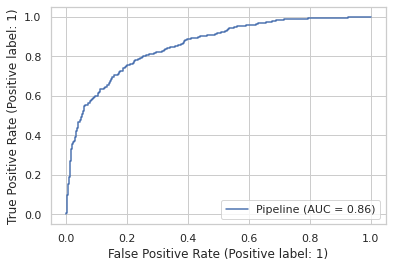

In [63]:
predict = rf_clf_best.predict(X_test)

print(f1_score(y_test, predict))

plot_roc_curve(rf_clf_best, X_test, y_test);

## Вывод

В данном проекте была поставлена задача прогнозирования - уйдет ли клиент из банка или нет. Ключевой метрикой была выбрана `F1-мера`.

В ходе проекта был проведен анализ данных, который показал, что более 50% ушедших клиентов - это клиенты возраста от 50 до 60 лет. Так же более 40% уходят в категориях 45-50 лет и 60-65 лет. Так же были заполнены пропуски.

Данные были преобразованы с помощью `StandardScaler` и `OneHotEncoding`.

В данных присутсвовал сильный дисбаланс классов, который преодолевался 3 методами:
1. `upsample`;
2. `downsample`;
3. `class_weight=balanced`.

Для решения данной задачи, которая относится к классификации, были выбраны 3 модели:
1. `LogisticRegression`;
2. `RandomForest`;
3. `Support Vector Machine`.

Модели одинаково хорошо показывали себя на всех этапах:
1. `baseline` ~ 52%;
2. `upsample` ~ 57-58%,
3. `downsample` ~ 58-60%;
4. `class_weight=balanced` ~ 58-59%.

При применении техник `upsample` и `downsample` модели переобучались и на валидации показывали меньшие результаты.

Для настройки гиперпараметров и прогнозирования была выбрана модель `Random Forest` с обучением на данных с применением `downsample`. По итогам применения модели к тестовым данным показатель `F1` равен 0.614. Так же была построена ROC-AUC для данной модели, площадь под кривой оказалась равной 0.85, что значительно больше, чем у случайной модели.